In [12]:
# importing libraries.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import eigsh


In [13]:
# Assigning Constants.
kx = 1
ky = 1
kxy = 0.5
m = 1
hbar = 1.0
N_t = 10000   
N_q = 1200   
q_max = 6.0  

In [14]:
# Defining graphing functions.
def plot(x_value, y_value, xlabel=None, ylabel=None, title=None, color=None,
         label=None, show=True, newfig=True, dpi=150):
    if newfig:
        plt.figure(dpi=dpi)
    plt.plot(x_value, y_value, color=color, label=label)
    if xlabel: plt.xlabel(xlabel)
    if ylabel: plt.ylabel(ylabel)
    if title:  plt.title(title)
    plt.grid(True)
    if label is not None: plt.legend()
    plt.savefig(f"{"Results/figures"}/{title}.png")
    if show: plt.show()

def plot_on_ax(ax, x, y, xlabel=None, ylabel=None, title=None, color=None):
    ax.plot(x, y, color=color)
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if title:  ax.set_title(title)
    ax.grid(True)

In [15]:

# Getting accelerations, velocity and positions.
def motion(t, state):
    x, y, vx, vy = state
    ax = (-kx*x - kxy*y)/m
    ay = (-ky*y - kxy*x)/m
    return [vx, vy, ax, ay]

t = np.linspace(0, 20, N_t)
state0 = [1,0,0,2]
sol = solve_ivp(motion, [0,20], state0, t_eval=t, rtol = 1e-9, atol=1e-12)
x, y, vx, vy = sol.y[0], sol.y[1], sol.y[2], sol.y[3]

In [16]:
# Solving for the normal modes.
Kmat = np.array([[kx, kxy],
                 [kxy, ky]], dtype=float)
lam, R = np.linalg.eigh(Kmat)
lambda1, lambda2 = lam
omega = np.sqrt(lam/m)

pos = np.vstack([x, y])        
vel = np.vstack([vx, vy])     
Q = R.T @ pos                  
Qdot = R.T @ vel               

Q1, Q2 = Q[0] , Q[1]
Qdot1, Qdot2 = Qdot[0], Qdot[1]

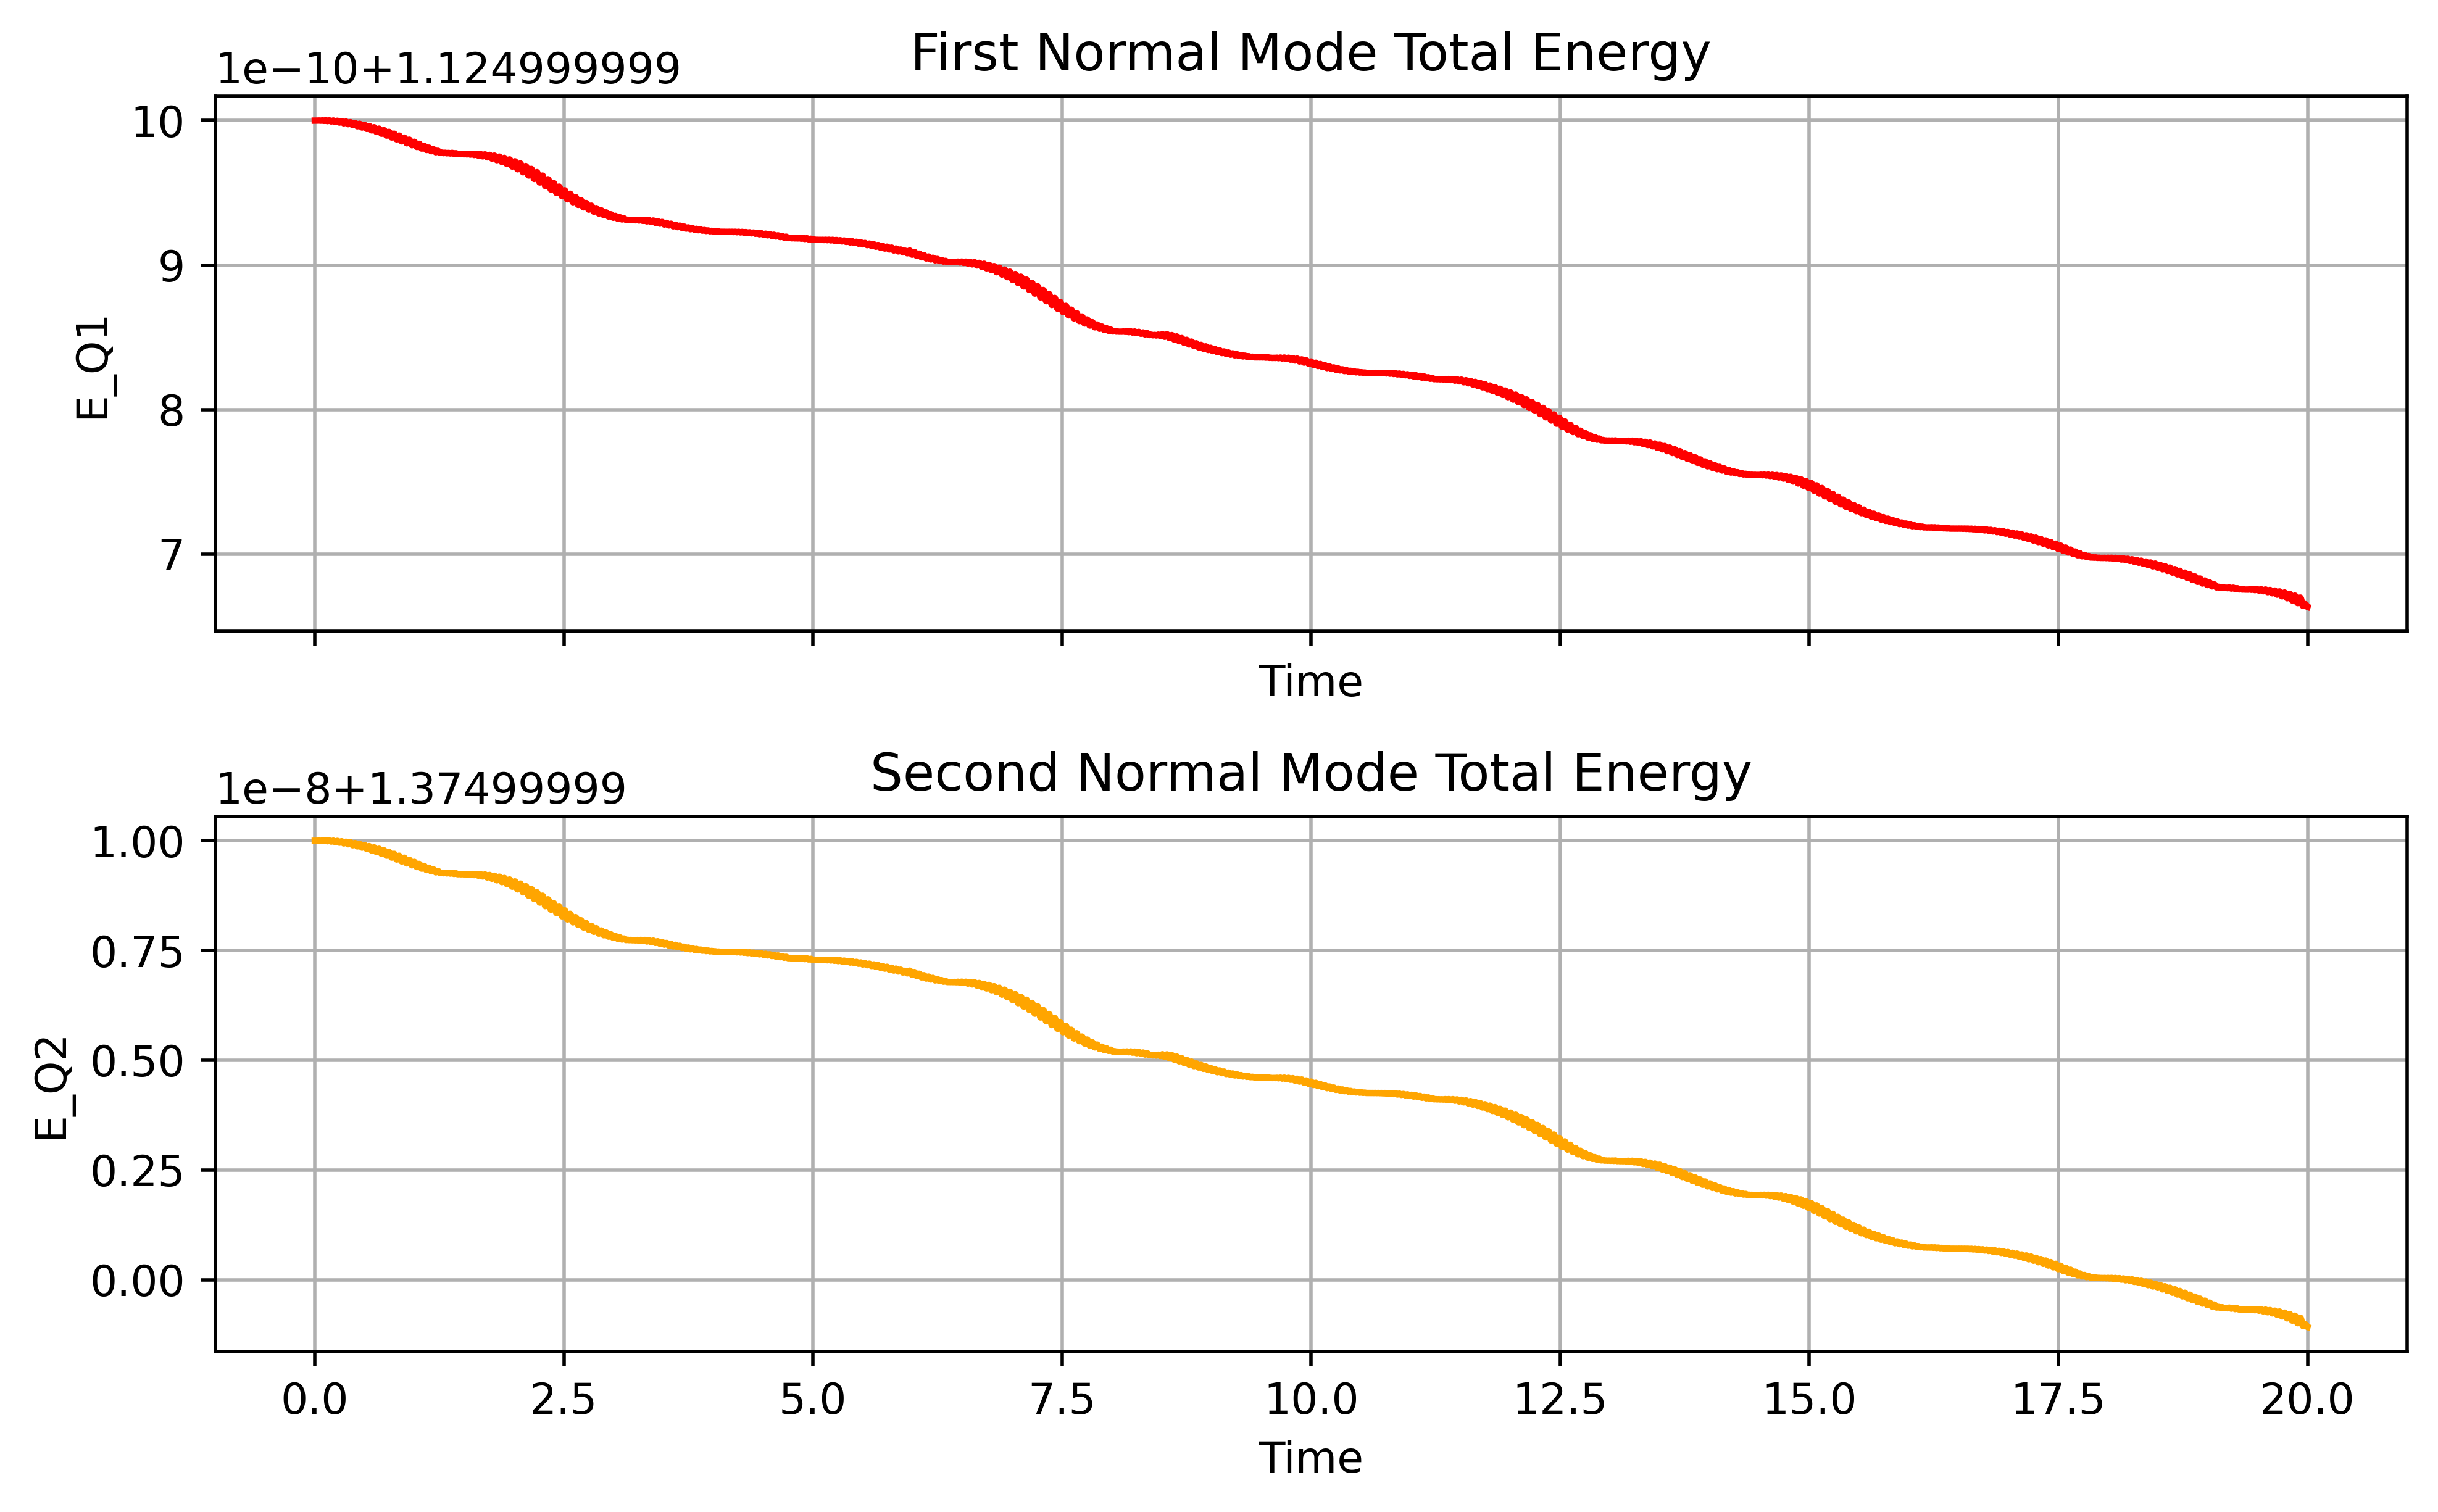

In [17]:
# Classical energy for normal modes
V_Q1 = 0.5 * lambda1 * Q1**2
T_Q1 = 0.5 * m * Qdot1**2
E_Q1 = T_Q1 + V_Q1

V_Q2 = 0.5 * lambda2 * Q2**2
T_Q2 = 0.5 * m * Qdot2**2
E_Q2 = T_Q2 + V_Q2

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 5), dpi=500)

plot_on_ax(ax[0], t, E_Q1, xlabel='Time', ylabel='E_Q1', title='First Normal Mode Total Energy', color='red')
plot_on_ax(ax[1], t, E_Q2, xlabel='Time', ylabel='E_Q2', title='Second Normal Mode Total Energy', color='orange')

fig.tight_layout()
plt.savefig(f"{"Results/figures"}/Total_Energy_of_Normal_Modes.png")

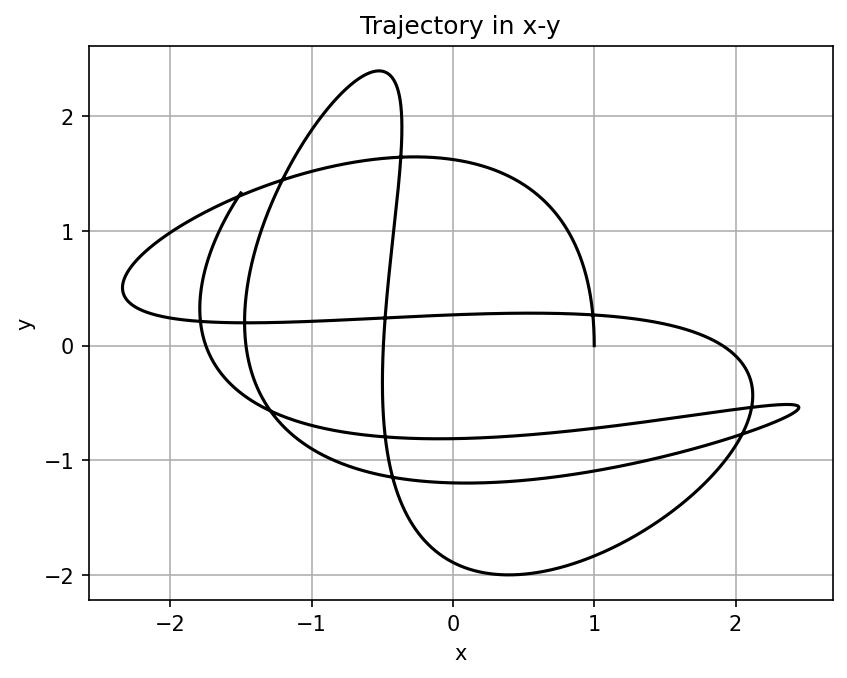

In [18]:
# Plotting positions.
plot(x, y, 'x', 'y', 'Trajectory in x-y', color='black')
# Note: if you want equal scaling for x-y trajectory, use the explicit plotting block instead of the helper.


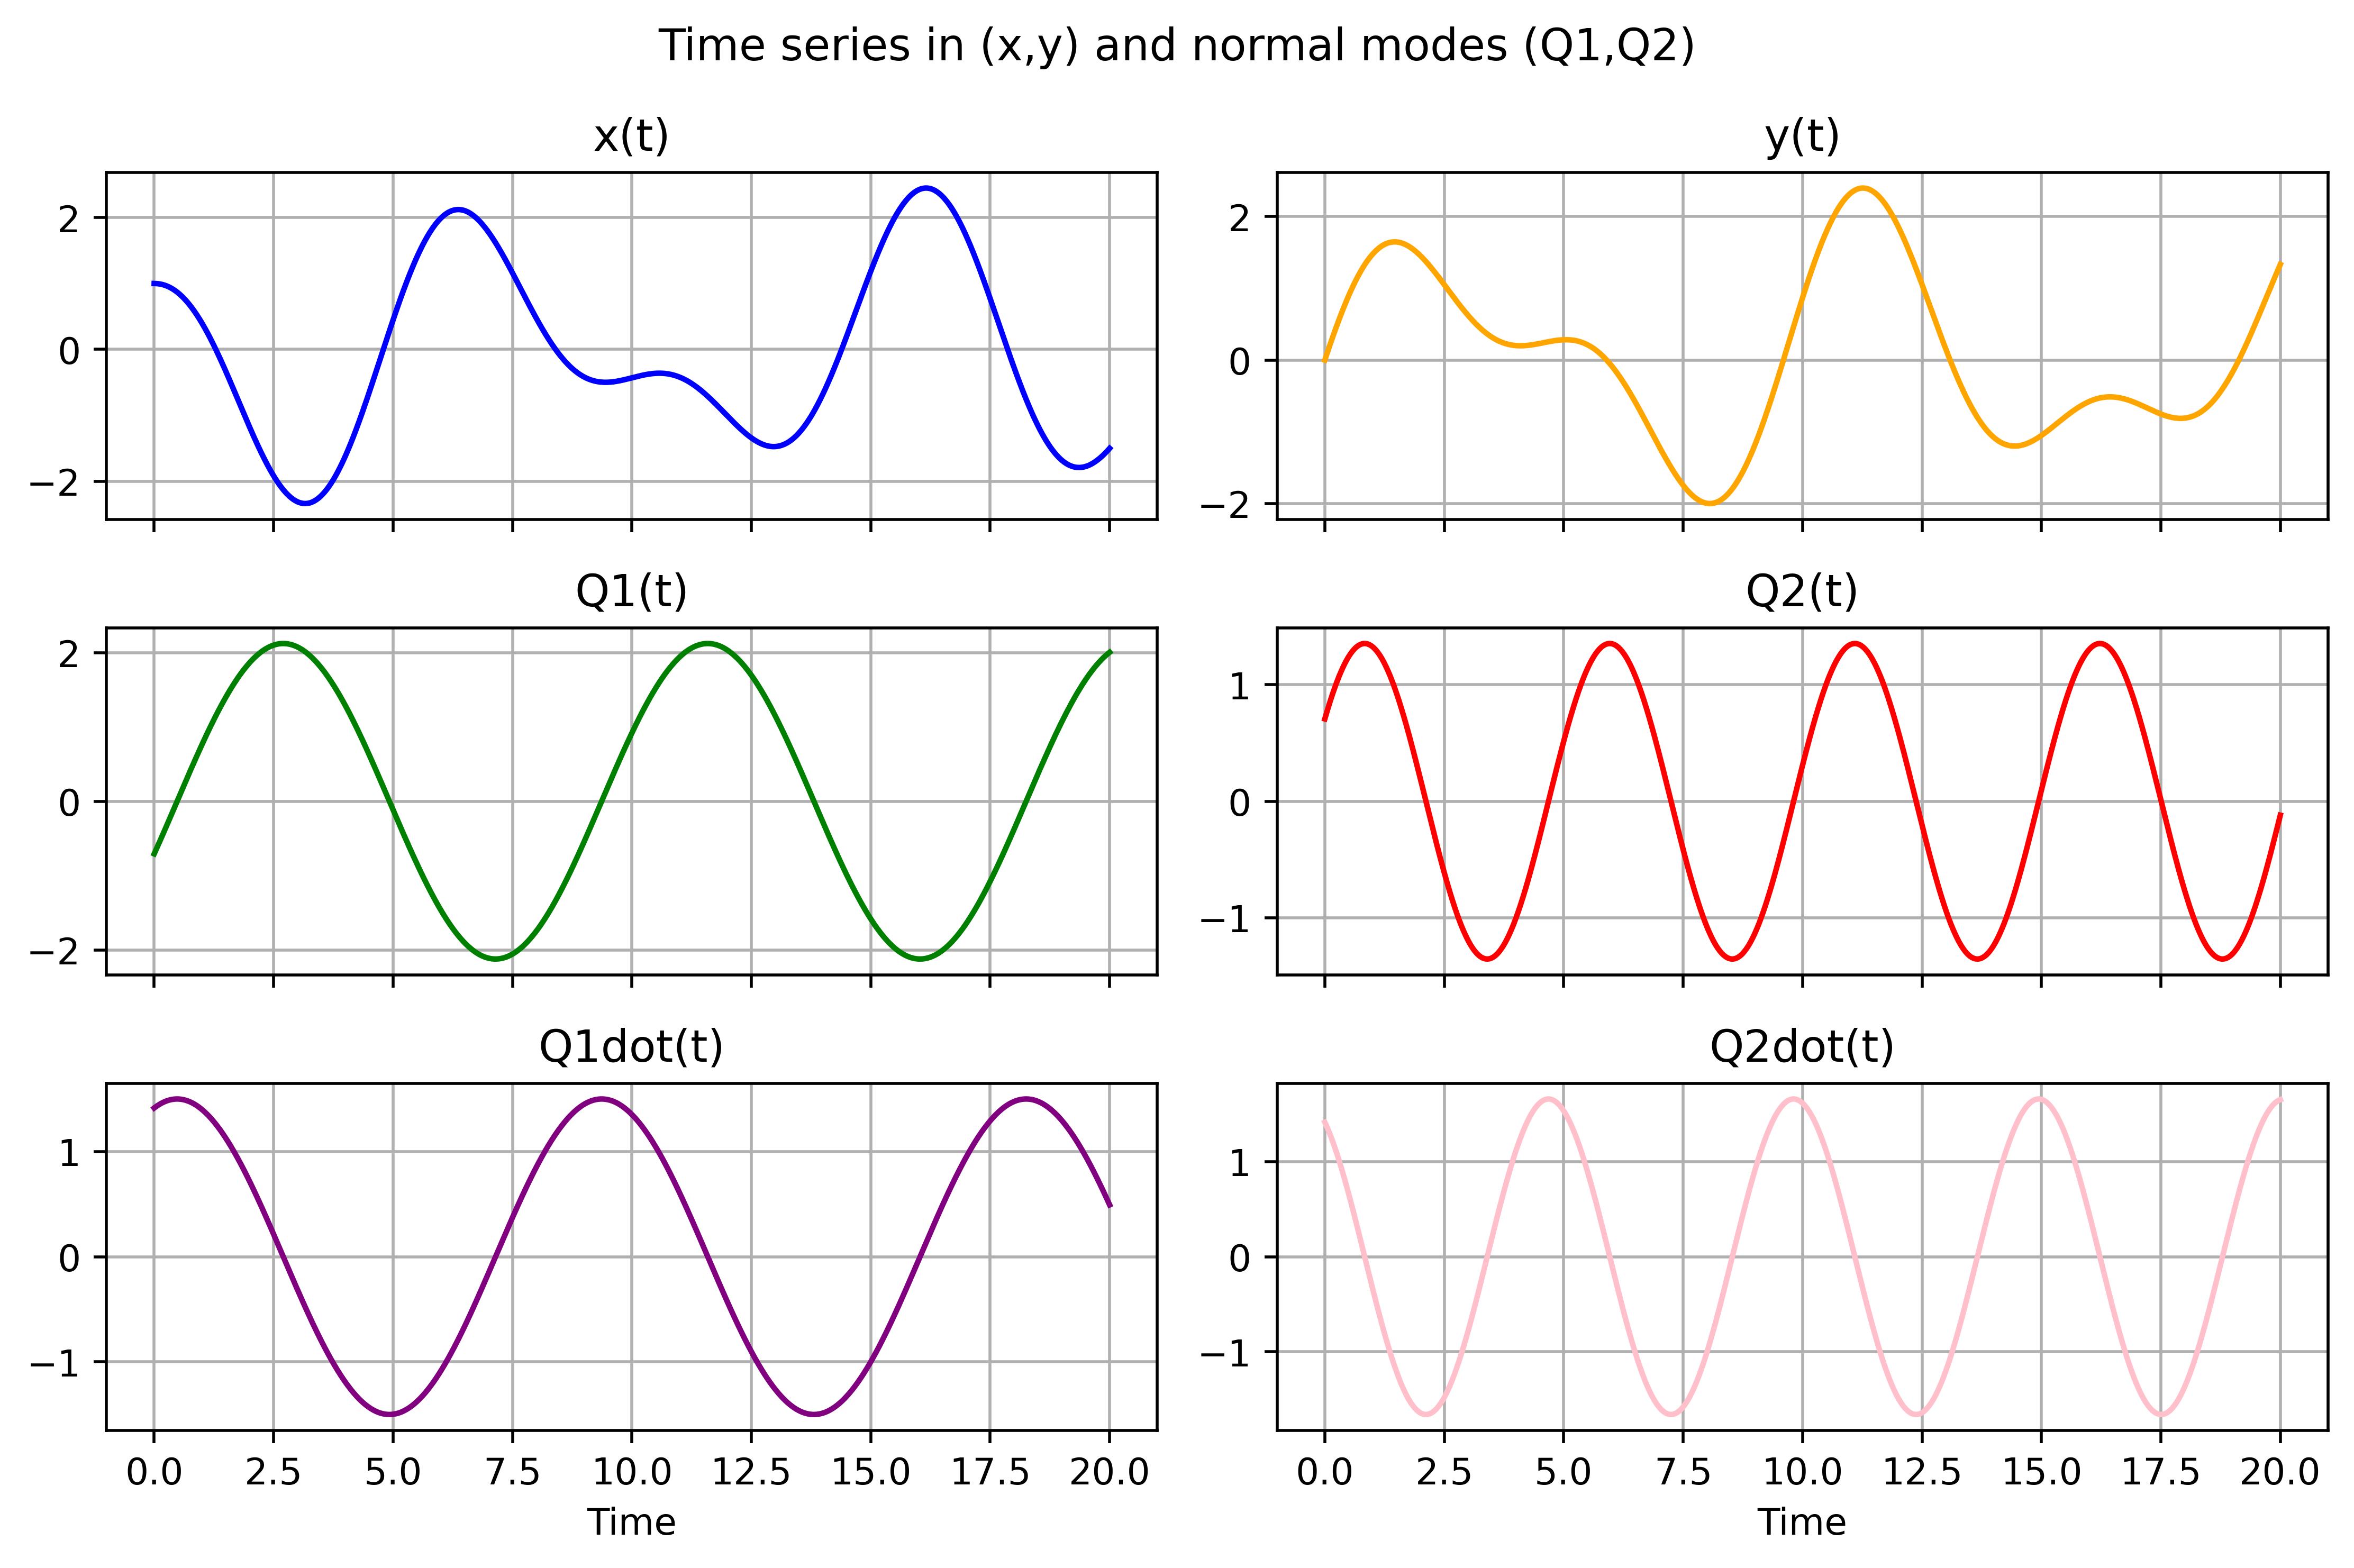

In [19]:

# Plotting time series in (x,y) and normal modes (Q1,Q2)
fig, ax = plt.subplots(3, 2, figsize=(9, 6), sharex=True, dpi=500)

plot_on_ax(ax[0,0], t, x, title='x(t)', color='blue')
plot_on_ax(ax[0,1], t, y, title='y(t)', color='orange')

plot_on_ax(ax[1,0], t, Q1, title='Q1(t)', color='green')
plot_on_ax(ax[1,1], t, Q2, title='Q2(t)', color='red')

plot_on_ax(ax[2,0], t, Qdot1, xlabel='Time', title='Q1dot(t)', color='purple')
plot_on_ax(ax[2,1], t, Qdot2, xlabel='Time', title='Q2dot(t)', color='pink')

fig.suptitle('Time series in (x,y) and normal modes (Q1,Q2)')
fig.tight_layout()
plt.savefig(f"{"Results/figures"}/Time_series_and_normal_modes.png")
plt.show()

In [20]:
# Build a uniform grid for Q
q = np.linspace(-q_max, q_max, N_q)
dq = q[1] - q[0]

# Finite-difference second derivative operator: d2/dq2
main = -2.0 * np.ones(N_q)
off = 1.0 * np.ones(N_q - 1)
D2 = diags([off, main, off], offsets=[-1, 0, 1], format='csr') / (dq**2)


# Solve the 1D eigenproblem for a given mode and getting the wavefunctions.
def solve_mode(lambda_i, mode_name, num_states=4):
    # Potential operator: (1/2) lambda q^2
    V = 0.5 * lambda_i * q**2
    V_op = diags(V, 0, format='csr')

    # Kinetic operator: -(hbar^2/2m) d2/dq2
    T_op = -(hbar**2) / (2.0 * m) * D2

    H_op = T_op + V_op

    # Solve for lowest `num_states` eigenpairs
    E, psi = eigsh(H_op, k=num_states, which='SA')

    # Sort (eigsh doesn't guarantee order)
    idx = np.argsort(E)
    E = E[idx]
    psi = psi[:, idx]

    # Normalize eigenvectors on the grid: sum |psi|^2 dq = 1
    for j in range(psi.shape[1]):
        norm = np.sqrt(np.sum(np.abs(psi[:, j])**2) * dq)
        psi[:, j] = psi[:, j] / norm

    print(f"\n{mode_name}: lambda={lambda_i:.6g}, omega={np.sqrt(lambda_i/m):.6g}")
    for n in range(num_states):
        print(f"  n={n}: E={E[n]:.6g}")
   
    return E, psi

E1, psi1 = solve_mode(lambda1, 'Mode 1 (Q1)')
E2, psi2 = solve_mode(lambda2, 'Mode 2 (Q2)')



Mode 1 (Q1): lambda=0.5, omega=0.707107
  n=0: E=0.353552
  n=1: E=1.06065
  n=2: E=1.76775
  n=3: E=2.47484

Mode 2 (Q2): lambda=1.5, omega=1.22474
  n=0: E=0.612368
  n=1: E=1.83709
  n=2: E=3.0618
  n=3: E=4.28649


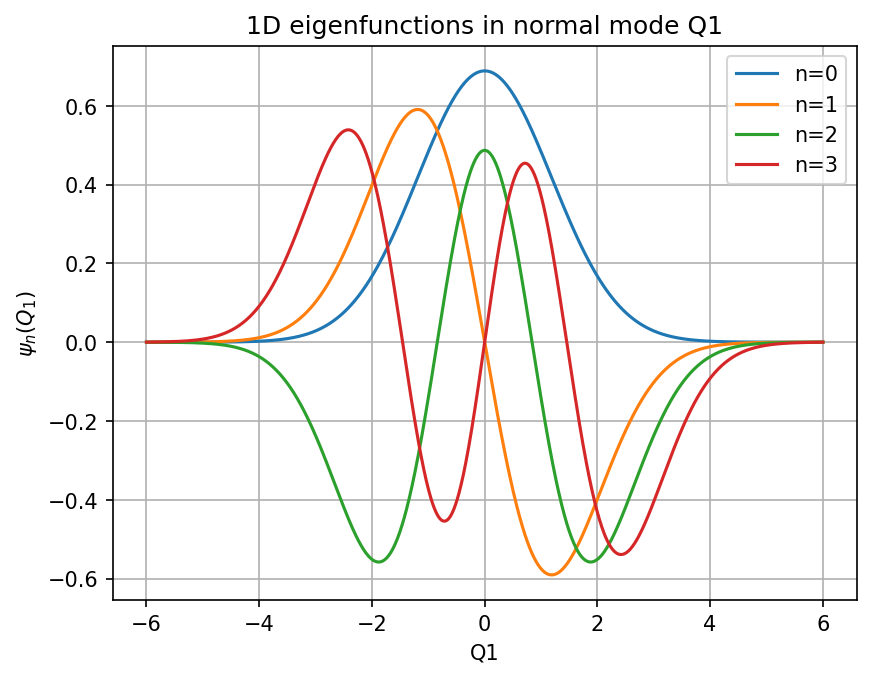

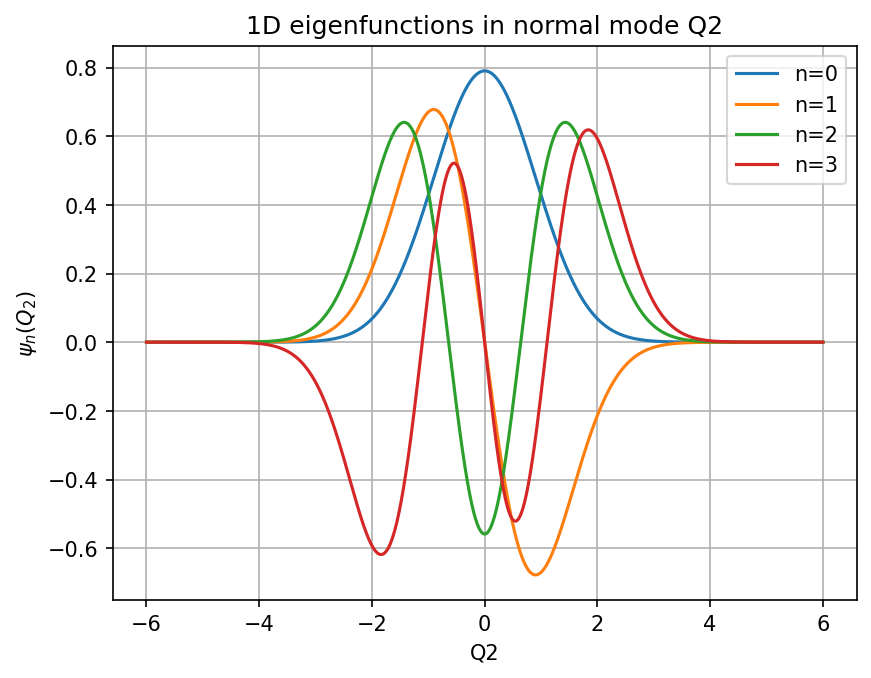

In [21]:
# Plot eigenfunctions: one figure for Q1, one figure for Q2
for n in range(4):
    plot(q, psi1[:, n], xlabel='Q1', ylabel=r'$\psi_n(Q_1)$',
         title='1D eigenfunctions in normal mode Q1',
         label=f'n={n}', show=False, newfig=(n==0))

plt.show()

for n in range(4):
    plot(q, psi2[:, n], xlabel='Q2', ylabel=r'$\psi_n(Q_2)$',
         title='1D eigenfunctions in normal mode Q2',
         label=f'n={n}', show=False, newfig=(n==0))
plt.show()

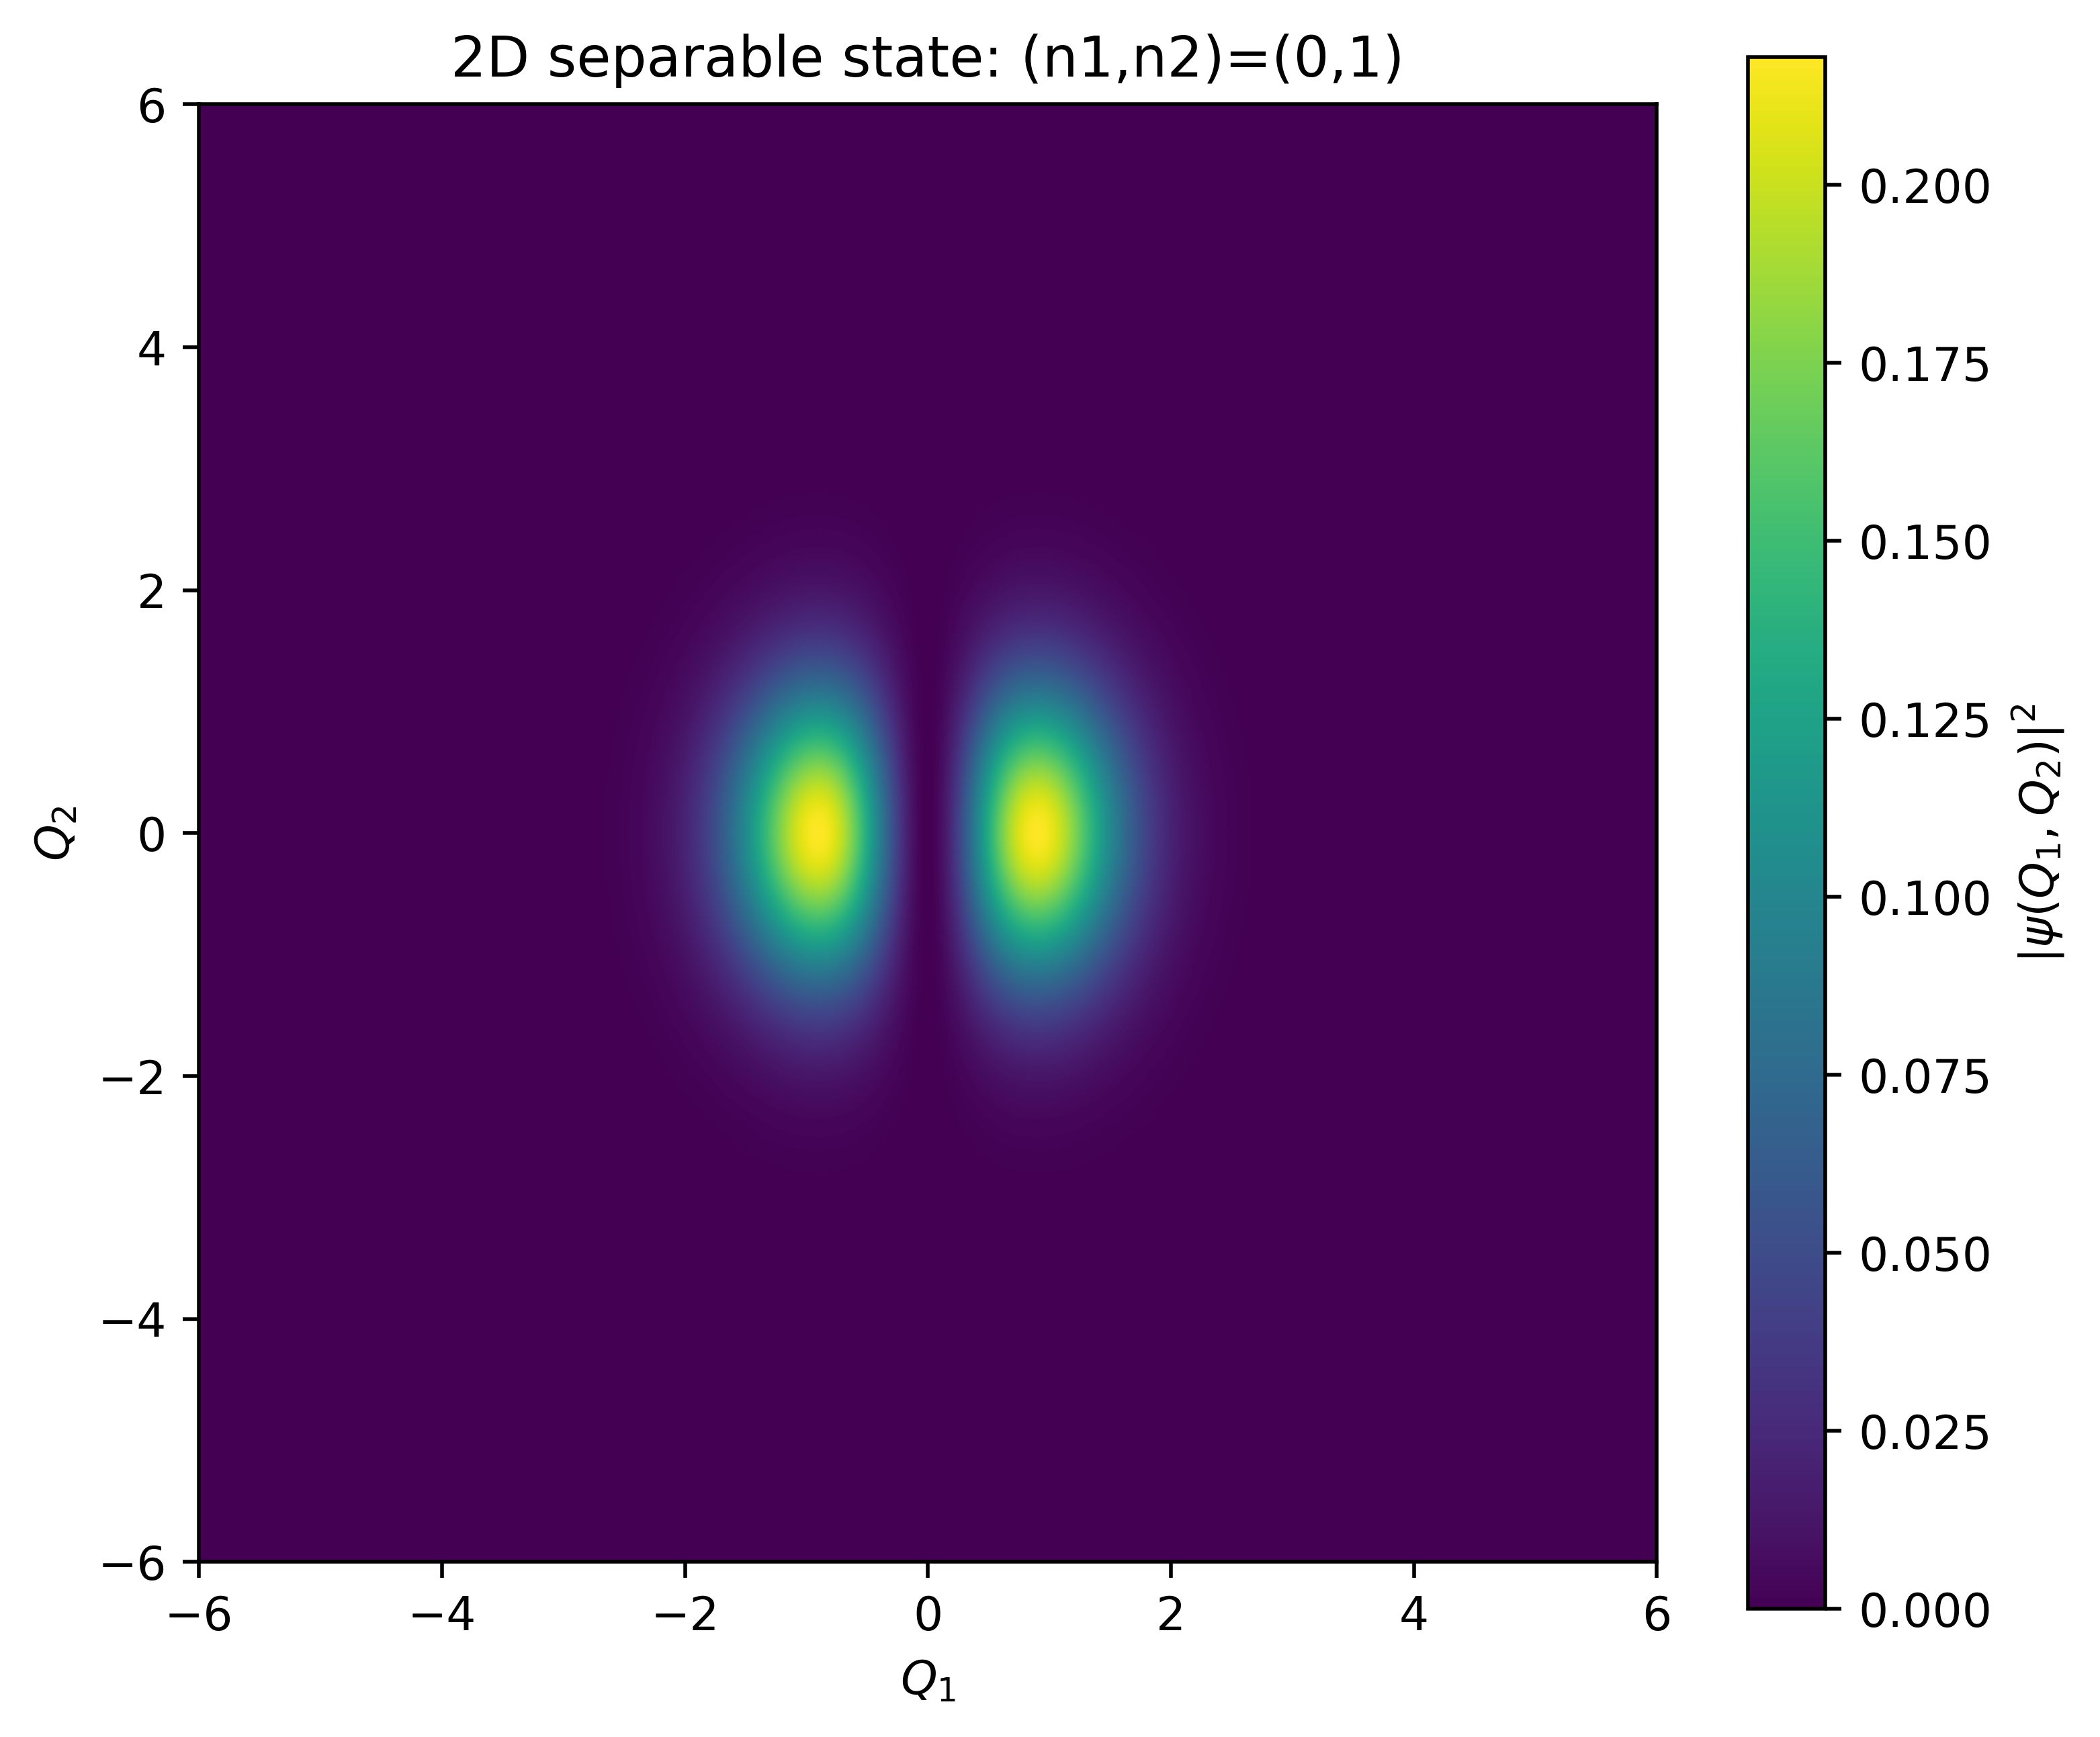

In [22]:
# Example 2D separable probability density in (Q1,Q2): |psi_{n1}(Q1) psi_{n2}(Q2)|^2
n1, n2 = 0, 1
Psi2D = np.outer(psi1[:, n1], psi2[:, n2])
Prob2D = np.abs(Psi2D)**2

plt.figure(figsize=(7, 6),dpi=500)
plt.imshow(
    Prob2D,
    extent=[-q_max, q_max, -q_max, q_max],
    origin='lower',
    aspect='equal'
)
plt.colorbar(label=r'$|\psi(Q_1,Q_2)|^2$')
plt.xlabel(r'$Q_1$')
plt.ylabel(r'$Q_2$')
plt.title(f'2D separable state: (n1,n2)=({n1},{n2})')
plt.savefig(f"{"Results/figures"}/2D_probability.png")
plt.show()